These imports provide tools for data processing, localization, and validation: geopy (with Nominatim) and pycountry enable city-to-country conversions, re handles email extraction via pattern matching, and pandas facilitates data manipulation within structured DataFrames. Additionally, datetime allows for date handling, while phonenumbers (alongside geocoder and carrier) standardizes and validates phone numbers with international formatting. Together, these libraries support the parsing, cleaning, and structuring of contact information.

In [1]:
from geopy.geocoders import Nominatim
import re

import pandas as pd
from datetime import datetime

import phonenumbers
from phonenumbers import geocoder, carrier

import pycountry

merge_duplicates
This function consolidates duplicate contact records in a DataFrame. Duplicates are detected based on either Full Name or Email. For each set of duplicates, it:

Keeps the most recent entry (determined by the technical_test___create_date).
Merges information from older records if there’s missing data in the recent entry.
Concatenates unique industry values with semicolons.

In [2]:
def merge_duplicates(df):
    """
    Merges duplicate contact records in a DataFrame based on email or full name, keeping the most recent record
    and merging data from older records according to specified criteria.

    Args:
        df (pd.DataFrame): DataFrame containing contact records with columns 'hs_object_id', "Full Name"('firstname'+'lastname'),
                           'raw_email', 'address', 'industry', and  'technical_test___create_date'.

    Returns:
        pd.DataFrame: A DataFrame with duplicates merged and only the most recent records retained.
    """

    # Ensure the create date is in datetime format for comparison
    df["technical_test___create_date"] = pd.to_datetime(df["technical_test___create_date"], format="%Y-%m-%d")


    # First Step: Merge duplicates based on Full Name
    df = merge_by_key(df, "Full Name")

    # Second Step: Merge duplicates based on Email
    df = merge_by_key(df, "Email")

    return df

merge_by_key
A helper function for merge_duplicates, this function performs the merging based on a specified key (e.g., Full Name or Email). It:

Sorts entries by technical_test___create_date.
Groups records by the specified key, allowing identification of duplicates.
Merges details from older records into the most recent record within each duplicate group.

In [3]:
def merge_by_key(df, key):
    """
    Helper function to merge duplicates based on a specified key.

    Args:
        df (pd.DataFrame): DataFrame to be processed.
        key (str): The column name to use as the grouping key (e.g., "Full Name" or "Email").

    Returns:
        pd.DataFrame: A DataFrame with duplicates merged based on the specified key.
    """

    # Sort by create date in descending order so the most recent record comes first
    df = df.sort_values(by="technical_test___create_date", ascending=False)

    if "Full Name" in key:
        # Create a unique identifier based on email and full name
        df["unique_id"] = (df['firstname']+df['lastname']).fillna("")
        # Group by the specified key to detect duplicates
        grouped = df.groupby("unique_id")
    elif "Email" in key:
        # Group by the specified key to detect duplicates
        grouped = df.groupby('raw_email')
    

    # Initialize an empty list to store merged records
    merged_records = []

    # Process each group of duplicates
    for _, group in grouped:
        # Start with the most recent record (first in sorted group)
        primary_record = group.iloc[0].copy()

        # Collect unique industries
        industry_set = set(primary_record["industry"].split(";")) if pd.notna(primary_record["industry"]) else set()

        # Iterate through other records in the group (older records)
        for _, row in group.iloc[1:].iterrows():
            # Fill missing fields in the primary record
            for column in ["address", "industry"]:
                if pd.isna(primary_record[column]) and pd.notna(row[column]):
                    primary_record[column] = row[column]

            # Concatenate unique industry values
            if pd.notna(row["industry"]):
                industry_set.update(row["industry"].split(";"))

        # Format the industry field as required
        primary_record["industry"] = ";" + ";".join(sorted(industry_set)).strip(";")

        # Append the processed primary record to the list of merged records
        merged_records.append(primary_record)

    # Create a DataFrame from the merged records list
    merged_df = pd.DataFrame(merged_records)

    return merged_df

get_country_code_from_city
Uses a city name to find the corresponding ISO Alpha-2 country code. It:

Geocodes the city name to locate the country.
Extracts and converts the country name to an Alpha-2 code using pycountry.

In [4]:
def get_country_code_from_city(city_name):
    """
    Returns the ISO Alpha-2 country code based on the city name.

    Args:
        city_name (str): The name of the city.

    Returns:
        str: The ISO Alpha-2 country code if found, otherwise an error message.
    """
    # Initialize the geolocator
    geolocator = Nominatim(user_agent="city_to_country_code")

    # Geocode the city to find the country
    location = geolocator.geocode(city_name)
    
    if location:
        # Extract country name from the location
        
        country_name = location.address.split(",")[-1].strip()

        if "/" in country_name:
            country_name = country_name.split("/")[1].strip()
        
    
        # Use pycountry to find the ISO country code
        country = pycountry.countries.get(name=country_name)
        
        if country:
            return country.alpha_2  # Return the Alpha-2 country code
        else:
            return "Country code not found in pycountry"
    else:
        return "City not found"

format_phone_number
Formats a phone number using the country code provided. It:

Removes non-numeric characters from the phone number.
Strips leading zeros or 00 (replacing with the country code if necessary).
Parses the phone number and applies a standard format with the country code.

In [5]:
def format_phone_number(phone, country_code):
    """
    Formats a phone number with the country code and ensures it adheres to a standard format.

    Args:
        phone (str): The phone number as a string.
        country_code (str): The ISO Alpha-2 country code to interpret the number.

    Returns:
        str: The formatted phone number or an error message if invalid.
    """
    # Clean the phone number by removing any non-numeric characters
    phone = ''.join(filter(str.isdigit, phone))

    # If the phone starts with '00', replace it with the country code
    if phone.startswith("00"):
        phone = phone[2:]

    if phone.startswith("0"):
        phone = phone[1:]
    

    # Prepend the country code if not already present
    try:
        parsed_number = phonenumbers.parse(phone, country_code)

        code = str(parsed_number).split(" ")[2].strip()
        
        custom_format= f"(+{code}) {phone}"

        return custom_format

    except phonenumbers.phonenumberutil.NumberParseException:
        return "Could not parse the phone number"

extract_emails
Extracts email addresses from a string or list of strings. It:

Uses a regular expression to locate email patterns.
Returns a list of valid email addresses found in the input.

In [6]:
def extract_emails(text_input):
    """
    Extracts email addresses from a string or list of text strings.

    Args:
        text_input (str or list): A single string or list of text strings potentially containing email addresses.

    Returns:
        list: A list of extracted email addresses.
    """
    # Ensure the input is a list
    if isinstance(text_input, str):
        text_input = [text_input]

    # Regular expression pattern to match email addresses
    email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'

    # Extract and collect emails that match the pattern
    extracted_emails = []
    for text in text_input:
        emails = re.findall(email_pattern, text)
        extracted_emails.extend(emails)

    return extracted_emails

get_country_from_city
Determines the country based on a city name or a list of city names. It:

Geocodes each city to retrieve location information.
Extracts and returns the country associated with each city.

In [7]:
def get_country_from_city(city_name_input):
    """
    Returns a list of countries based on provided city names.

    Args:
        city_name_input (str or list): A single city name or a list of city names as strings.

    Returns:
        list: A list of country names corresponding to the input cities.
    """
    # Ensure the input is a list
    if isinstance(city_name_input, str):
        city_name_input = [city_name_input]

    # Initialize the Nominatim geolocator (moved outside the loop to avoid redundant calls)
    geolocator = Nominatim(user_agent="city_to_country")

    # Initialize list to store extracted countries
    extracted_countries = []

    # Loop through each city name in the list
    for city in city_name_input:
        # Remove extra quotes from city names if present
        city = city.strip("'")

        # Geocode the city name
        location = geolocator.geocode(city)
        
        # Check if location was found and extract country
        if location:
            # Get the last part of the address (assumed to be the country)
            country = location.address.split(",")[-1].strip()
            extracted_countries.append(country)
        else:
            extracted_countries.append("Country not found")
        
    return extracted_countries

car
A simple visual feedback function that takes an operation code (op) as an argument:

If op is 0, it prints a truck graphic labeled “Data Imported.”
If op is 1, it prints a truck graphic labeled “Data Sent.” This visual feedback helps track data processing steps.

In [8]:
def car(op):
    if op == 0 :
        print()
        print("-------─────▄▌▐▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▌ ---------------------------------")
        print("-------───▄▄██▌█ ..Data Imported..      ---------------------------------")
        print("-------▄▄▄▌▐██▌█ ................       ---------------------------------")
        print("-------███████▌█▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▌ ---------------------------------")
        print("-------▀(@)▀▀▀▀▀▀▀(@)(@)▀▀▀▀▀▀▀▀▀▀▀▀(@)▀---------------------------------")
        print()
    elif op == 1:
        print()
        print("--------------------  ▌▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▐▄─────-------")
        print("---------------------     ....Data Sent...  █▌██▄▄───-------")
        print("---------------------       ...........     █▌██ ▐▄▄▄-------")
        print("--------------------- ▌▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄█▌███████-------")
        print("--------------------- ▀(@)▀▀▀▀▀▀▀▀▀▀▀▀(@)(@)▀▀▀▀▀▀▀(@)▀-------")
        print()

######################################################################
#                                                                    #
#            All previous commands are located in the                #
#           Tools.py file within the original document.              #
#                                                                    #
######################################################################

These imports bring essential libraries and modules for data handling, HTTP requests, and API interactions: pandas is used for organizing and manipulating data in DataFrames; requests enables sending HTTP requests to external APIs, such as HubSpot's. The datetime module helps manage and format date and time data, while pprint provides readable output formatting for complex data structures. The hubspot library, along with modules like BatchInputSimplePublicObjectInputForCreate and BatchInputSimplePublicObjectBatchInput, simplifies interactions with the HubSpot API, enabling batch creation and updates of contact data, with ApiException managing any API-related errors that may occur.

In [9]:
import pandas as pd
import requests

from datetime import datetime
from pprint import pprint
import hubspot as hubspot
from hubspot.crm.contacts import BatchInputSimplePublicObjectInputForCreate, ApiException
from hubspot.crm.contacts import BatchInputSimplePublicObjectBatchInput, ApiException
import matplotlib.pyplot as plt

These settings configure pandas to display the entire DataFrame without truncation in the console, which is useful for debugging and reviewing large datasets. Specifically, pd.set_option("display.max_rows", None) and pd.set_option("display.max_columns", None) allow all rows and columns to be shown; pd.set_option("display.width", None) adjusts the display width, and pd.set_option("display.max_colwidth", None) ensures all text within each cell is fully visible.

In [10]:
# Display full DataFrame without truncation in the console for debugging
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

This class, HubSpotDataPipeline, initializes with two API keys: api_key_from for authentication when extracting data and api_key_to for loading data into a HubSpot account. Inside __init__, the first key, api_key_from, is stored in self.api_key for headers used in HTTP requests, while api_key_to is passed to the HubSpot client for managing API operations. The headers dictionary sets up authorization and content type for API requests, and self.endpoint specifies the URL for searching contacts in HubSpot's CRM.

In [11]:
# Define the API key and endpoint URL
api_key = "HUBSPOT_API_KEY"  # actual HubSpot API key
endpoint = "https://api.hubapi.com/crm/v3/objects/contacts/search"

# Set up headers for authentication and data format
headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

extract()
This function retrieves contact data from HubSpot based on specific criteria:

Filters contacts by the allowed_to_collect property, ensuring only records marked as true are collected.
Defines key properties to retrieve, such as firstname, lastname, raw_email, and others.
Sends a request to the HubSpot API to collect contacts.
Organizes the data by sorting contacts alphabetically by lastname and by date.
Returns a list of contacts, each as a dictionary with key properties.

In [12]:
def Extract():
    """
    Collects all contact records marked as 'allowed_to_collect' = true
    and sorts them alphabetically by 'lastname'. Retrieves specified contact
    properties from HubSpot and returns a list of organized contacts.

    Returns:
        list: A sorted list of dictionaries, each containing contact details.
    """
    
    # Define the properties to be collected for each contact
    properties = [
        "firstname", "lastname", "raw_email", "country", "phone",
        "technical_test___create_date", "industry", "address", "hs_object_id"
    ]

    # Define the body of the search request with filter criteria
    request_body = {
        "filterGroups": [
            {
                "filters": [
                    {
                        "propertyName": "allowed_to_collect",
                        "operator": "EQ",
                        "value": "true"
                    }
                ]
            }
        ],
        "properties": properties,
        "limit": 100  # Adjust the limit if necessary
    }

    # Make the POST request to fetch contacts
    try:
        response = requests.post(endpoint, headers=headers, json=request_body)
        response.raise_for_status()  # Check for HTTP errors
        data = response.json()

        # Extract and collect each contact's specified properties
        contacts = data.get("results", [])
        collected_contacts = []
        for contact in contacts:
            contact_details = {prop: contact["properties"].get(prop, None) for prop in properties}
            collected_contacts.append(contact_details)

        # Sort contacts alphabetically by 'lastname'
        sorted_contacts = sorted(collected_contacts, key=lambda x: x.get("lastname", "").lower())

        # Sort contacts by date (assuming date is in 'YYYY-MM-DD' format in the 'date' field)
        sorted_contacts = sorted(collected_contacts, key=lambda x: datetime.strptime(x.get('technical_test___create_date', "1900-01-01"), "%Y-%m-%d"))

        return sorted_contacts

    except requests.exceptions.RequestException as e:
        print("Error fetching contacts:", e)
        return None

transform()
This function processes the extracted contacts to clean and organize data:

Transforms contact data using functions from the Tools module to:
Extract and validate emails,
Retrieve the country and country code based on city,
Format phone numbers according to country codes.
Creates a DataFrame from the transformed data and saves it as contacts_data_transformation.csv for tracking.
Removes duplicates using Tools.merge_duplicates to ensure only unique contacts remain.
Returns a cleaned and deduplicated DataFrame.

In [13]:
def Transform(sorted_contacts):
    
    for row in sorted_contacts:
            if 'raw_email' in row:
                row['raw_email'] = extract_emails(row['raw_email'])[0]
            if 'country' in row:
                row['city'] = row['country']
                country = get_country_from_city(row['country'])[0]
                row['country'] = country
                row['phone'] = format_phone_number(row['phone'],get_country_code_from_city(country))

    result=pd.DataFrame(sorted_contacts)

    # Save the DataFrame to a CSV file
    result.to_csv("contacts_data_transformation.csv", index=False)
    print()
    print("Data saved to contacts_data_transformation.csv")
    print()


    # Load the CSV file into a DataFrame
    result = pd.read_csv("contacts_data_transformation.csv")

    result=merge_duplicates(result)
    print(result)
    return result

load()
This function loads the cleaned contact data into HubSpot in bulk:

Prepares contacts by iterating through each row of the DataFrame to format data for the HubSpot API.
Creates a batch input object, which structures multiple contacts for a single API call.
Uploads contacts to HubSpot using batch_api.create(), creating new contact records with relevant properties.
Handles API errors with ApiException, displaying any issues encountered during the loading process.

In [14]:
def Load(df):
    """
    Creates multiple contacts in HubSpot in batch.

    Args:
        df (pd.DataFrame): DataFrame containing contact data with columns such as 'email', 'phone_number', 'country', etc.
    """
    # HubSpot API base URL and endpoint for creating contacts
    BASE_URL = "https://app.hubspot.com/private-apps/47865434"
    CONTACTS_ENDPOINT = "/crm/v3/objects/contacts/batch/create"
    api_key = "HUBSPOT_API_KEY"  #  actual HubSpot API key

    #client = HubSpot(api_key=api_key)
    client = hubspot.Client.create(access_token=api_key)
    
        
    batch_contacts = []

    for _, row in df.iterrows():
        # Convert 'technical_test___create_date' to a timestamp in milliseconds
        create_date = pd.to_datetime(row.get("technical_test___create_date")).value // 10**6

        # Prepare each contact's data for batch input
        contact_data = {
            "properties": {
                "email": row.get("raw_email"),
                "phone": row.get("phone"),
                "country": row.get("country"),
                "city": row.get("city"),  # Ensure 'city' is taken from the correct field
                "firstname": row.get("firstname"),
                "lastname": row.get("lastname"),
                "address": row.get("address"),
                "original_create_date": create_date,  # Set as a timestamp in milliseconds
                "original_industry": ";" + ";".join(row.get("industry", "").split(";")),
                "temporary_id": row.get("hs_object_id")
            }
        }
        batch_contacts.append(contact_data)

    # Create a BatchInput object
    batch_input = BatchInputSimplePublicObjectInputForCreate(inputs=batch_contacts)

    # Perform the batch create request
    try:
        api_response = client.crm.contacts.batch_api.create(batch_input_simple_public_object_input_for_create=batch_input)
        pprint(api_response)
        print("Batch creation completed successfully.")
    except ApiException as e:
        print("Exception when calling batch_api->create: %s\n" % e)



batch_update_contacts()
This function updates existing contacts in HubSpot:

Prepares data for update by creating a batch input with specified contact properties.
Identifies each contact using idProperty set to temporary_id, ensuring correct records are updated.
Sends the update request to HubSpot in bulk using batch_api.update(), applying changes to each contact’s information.
Handles errors by catching exceptions, printing out any issues during the batch update.

In [15]:
def batch_update_contacts(df, id_property="hs_object_id"):
    """
    Updates multiple contacts in HubSpot in batch.

    Args:
        df (pd.DataFrame): DataFrame containing contact data with columns such as 'raw_email', 'phone', 'country', etc.
        id_property (str): The unique property name used to identify each contact in HubSpot.
    """

    # HubSpot API base URL and endpoint for creating contacts
    BASE_URL = "https://app.hubspot.com/private-apps/47865434"
    CONTACTS_ENDPOINT = "/crm/v3/objects/contacts/batch/create"
    api_key = "HUBSPOT_API_KEY"  #  actual HubSpot API key

    #client = HubSpot(api_key=api_key)
    client = hubspot.Client.create(access_token=api_key)
    
     # Prepare the batch data for contacts
    batch_contacts = []

    for _, row in df.iterrows():
        # Convert 'technical_test___create_date' to a timestamp in milliseconds
        create_date = pd.to_datetime(row.get("technical_test___create_date")).value // 10**6

        # Prepare each contact's data for batch input
        contact_data = {
            "idProperty": "temporary_id",  # Use 'hs_object_id' as the unique identifier for updating contacts
            "id": row.get("hs_object_id"),
            "properties": {
                "email": row.get("raw_email"),
                "phone": row.get("phone"),
                "country": row.get("country"),
                "city": row.get("city"),
                "firstname": row.get("firstname"),
                "lastname": row.get("lastname"),
                "address": row.get("address"),
                "original_create_date": create_date,  # Set as a timestamp in milliseconds
                "original_industry": ";" + ";".join(row.get("industry", "").split(";")),
                "temporary_id": row.get("hs_object_id")
            }
        }
        batch_contacts.append(contact_data)

    # Create a BatchInput object
    batch_input = BatchInputSimplePublicObjectBatchInput(inputs=batch_contacts)

    # Perform the batch update request
    try:
        api_response = client.crm.contacts.batch_api.update(batch_input_simple_public_object_batch_input=batch_input)
        pprint(api_response)
        print("Batch update completed successfully.")
    except ApiException as e:
        print("Exception when calling batch_api->update: %s\n" % e)



This code initializes the HubSpotDataPipeline class with API keys to manage data extraction, transformation, and loading into HubSpot. It first calls extract() to retrieve and organize contact data, then stores the extracted data in a CSV file named contacts_data_collect.csv. Next, transform() is applied to clean, format, and deduplicate the data, saving the transformed output as contacts_data_result.csv. Finally, load() uploads the transformed data to HubSpot in bulk. Throughout the process, visual indicators (car(0) for data import and car(1) for data export) provide user feedback on the pipeline's progress.

In [16]:
# Execute the function to collect and sort contacts
data_list = Extract()
data_frame=pd.DataFrame(data_list)

for contact in data_list:
    print(f"date: {contact['technical_test___create_date']} ,  email: {contact['raw_email']} , phone: {contact['phone']} ,  Name: {contact['firstname']} {contact['lastname']}  ,  Country:  {contact['country']}")

# Save the DataFrame to a CSV file
data_frame.to_csv("contacts_data_collect.csv", index=False)
print()
print("Data saved to contacts_data_collect.csv")

car(0)

date: 2021-01-04 ,  email: William <william_russell1943282178@deons.tech> Contact Info. , phone: 1-350-260-784 ,  Name: William Russell  ,  Country:  Dublin
date: 2021-01-09 ,  email: Zara <zara_rodwell1398442854@nickia.com> Contact Info. , phone: 6-777-367-783 ,  Name: Zara Rodwell  ,  Country:  Ireland
date: 2021-01-21 ,  email: William <william_butler903409012@infotech44.tech> Contact Info. , phone: 8-716-877-321 ,  Name: William Butler  ,  Country:  Waterford
date: 2021-01-22 ,  email: Wade <wade_anderson2007937750@deavo.com> Contact Info. , phone: 6-174-303-382 ,  Name: Wade Anderson  ,  Country:  London
date: 2021-01-25 ,  email: William <william_howard125389241@bauros.biz> Contact Info. , phone: 4-016-542-630 ,  Name: William Howard  ,  Country:  Ireland
date: 2021-01-26 ,  email: Wade <wade_squire203830735@gmail.com> Contact Info. , phone: 6-021-612-161 ,  Name: Wade Squire  ,  Country:  Dublin
date: 2021-01-27 ,  email: Wade <wade_olivier1315624253@hourpy.biz> Contact Info. , 

In [20]:
data_frame=Transform(data_list)
df=data_frame


Data saved to contacts_data_transformation.csv

   firstname    lastname                                 raw_email  \
93    Vivian     Russell         vivian_russell695390295@twace.org   
71      Wade   Alexander       wade_alexander330181759@cispeto.com   
8       Wade    Anderson       wade_anderson1689656165@cispeto.com   
61      Wade  Broomfield       wade_broomfield250795294@supunk.biz   
65      Wade       Evans          wade_evans1741289747@bretoux.com   
83      Wade      Garner           wade_garner1604106184@jiman.org   
88      Wade       Gates            wade_gates745196951@muall.tech   
60      Wade    Hamilton         wade_hamilton1831139772@qater.org   
92      Wade       Logan           wade_logan1436414589@gompie.com   
85      Wade      Norris            wade_norris61408865@elnee.tech   
96      Wade     Olivier           wade_olivier689563814@yahoo.com   
44      Wade   Partridge       wade_partridge1480773915@nimogy.biz   
52      Wade    Robinson        wade_robi

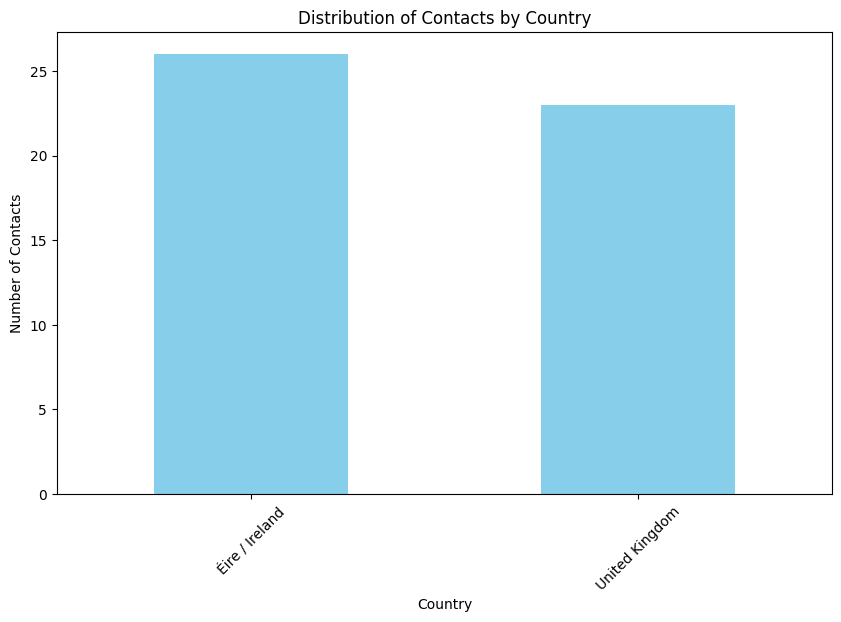

In [21]:
# Analysis 1: Distribution of contacts by country
country_counts = df['country'].value_counts()
plt.figure(figsize=(10, 6))
country_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Contacts by Country')
plt.xlabel('Country')
plt.ylabel('Number of Contacts')
plt.xticks(rotation=45)
plt.show()

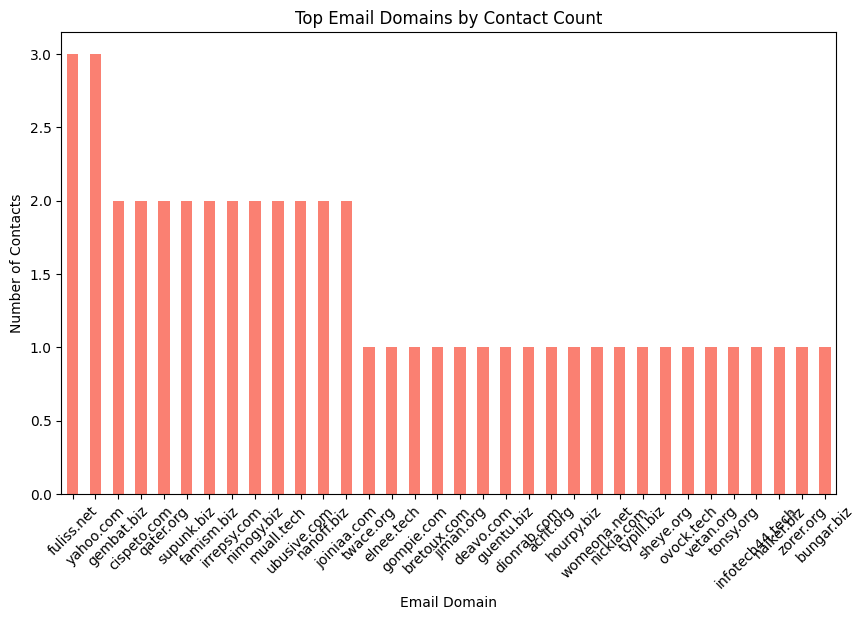

In [22]:
# Analysis 2: Top email domains by contact count
# Extract the email domain
df['email_domain'] = df['raw_email'].apply(lambda x: x.split('@')[-1] if pd.notna(x) else None)

# Count the frequency of each email domain
domain_counts = df['email_domain'].value_counts()

# Create bar chart of the most common email domains
plt.figure(figsize=(10, 6))
domain_counts.plot(kind='bar', color='salmon')
plt.title('Top Email Domains by Contact Count')
plt.xlabel('Email Domain')
plt.ylabel('Number of Contacts')
plt.xticks(rotation=45)
plt.show()

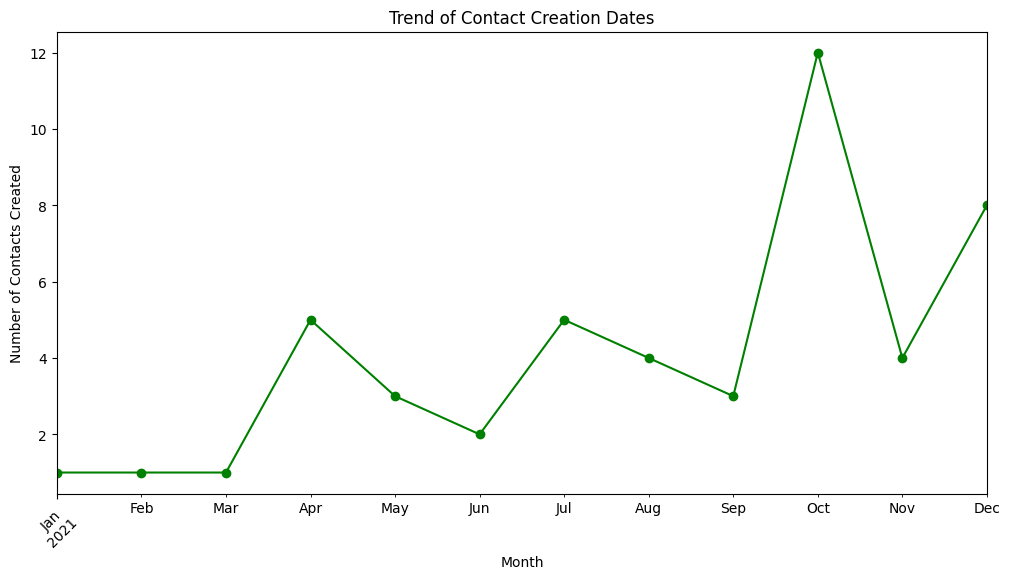

In [23]:
# Analysis 3: Contact creation trend over time
df['technical_test___create_date'] = pd.to_datetime(df['technical_test___create_date'])
date_counts = df['technical_test___create_date'].dt.to_period('M').value_counts().sort_index()
plt.figure(figsize=(12, 6))
date_counts.plot(kind='line', marker='o', color='green')
plt.title('Trend of Contact Creation Dates')
plt.xlabel('Month')
plt.ylabel('Number of Contacts Created')
plt.xticks(rotation=45)
plt.show()



In [24]:
# Save the DataFrame to a CSV file
data_frame.to_csv("contacts_data_result.csv", index=False)
print("Data saved to contacts_data_result.csv")

#batch_update_contacts(data_frame)
Load(data_frame)
car(1)

Data saved to contacts_data_result.csv
Exception when calling batch_api->create: (409)
Reason: Conflict
HTTP response headers: HTTPHeaderDict({'Date': 'Mon, 28 Oct 2024 18:32:06 GMT', 'Content-Type': 'application/json;charset=utf-8', 'Content-Length': '156', 'Connection': 'keep-alive', 'CF-Ray': '8d9d01b15d1867d2-MIA', 'CF-Cache-Status': 'DYNAMIC', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains; preload', 'Vary': 'origin, Accept-Encoding', 'access-control-allow-credentials': 'false', 'x-content-type-options': 'nosniff', 'x-hubspot-correlation-id': 'e9e444c4-c082-46cb-a973-a06a90396f2c', 'x-hubspot-ratelimit-daily': '1000000', 'x-hubspot-ratelimit-daily-remaining': '999984', 'x-hubspot-ratelimit-interval-milliseconds': '10000', 'x-hubspot-ratelimit-max': '190', 'x-hubspot-ratelimit-remaining': '189', 'x-hubspot-ratelimit-secondly': '19', 'x-hubspot-ratelimit-secondly-remaining': '18', 'Report-To': '{"endpoints":[{"url":"https:\\/\\/a.nel.cloudflare.com\\/report\\/v4?s